## Setup
Download dataset from Kaggle, import all necessary libraries, use CPU/GPU

In [ ]:
# Setup and download the dataset
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("jehanbhathena/weather-dataset")
dataset_path += '/dataset'

print("Path to dataset files:", dataset_path)

100%|██████████| 587M/587M [00:11<00:00, 54.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset preparation

In [ ]:
# Some images are in GIF format
invalid_images = ['fogsmog/4514.jpg', 'snow/1187.jpg']

for filename in invalid_images:
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if the file exists
        os.remove(file_path)  # Remove the file
        print(f'Removed {file_path}')

Removed /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset/fogsmog/4514.jpg
Removed /root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset/snow/1187.jpg


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,        
    width_shift_range=0.2,   
    height_shift_range=0.2,
    shear_range=0.2,         
    zoom_range=0.2,        
    horizontal_flip=True,  
    validation_split=0.2   
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224), 
    batch_size=128,             
    class_mode='categorical',  
    subset='training'       
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    shuffle = False
)

Found 5491 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


## Training

In [ ]:
model = Sequential([
    Input((224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

lr = 0.001

model.compile(
    optimizer=Adam(lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,401,739 (169.38 MB)

 Trainable params: 44,401,739 (169.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.2645 - loss: 2.4993 - val_accuracy: 0.5664 - val_loss: 1.4221
Epoch 2/30
 1/42 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.4297 - loss: 1.6039

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 439ms/step - accuracy: 0.4297 - loss: 1.6039 - val_accuracy: 0.5398 - val_loss: 1.4141
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.5154 - loss: 1.3909 - val_accuracy: 0.6430 - val_loss: 1.1332
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 517ms/step - accuracy: 0.5859 - loss: 1.1943 - val_accuracy: 0.6117 - val_loss: 1.1854
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5935 - loss: 1.2106 - val_accuracy: 0.6516 - val_loss: 1.0783
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 447ms/step - accuracy: 0.5703 - loss: 1.3096 - val_accuracy: 0.6695 - val_loss: 1.0436
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6250 - loss: 1.1252 - val_accuracy: 0.6625 - val_loss: 1.0554
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 473ms/step - accuracy: 0.6172 - loss: 1.0411 - val_accuracy: 0.6555 - val_loss: 1.0727
Epoch 9/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6258 - loss: 1.0829 - val_accuracy: 0.6820 - val_

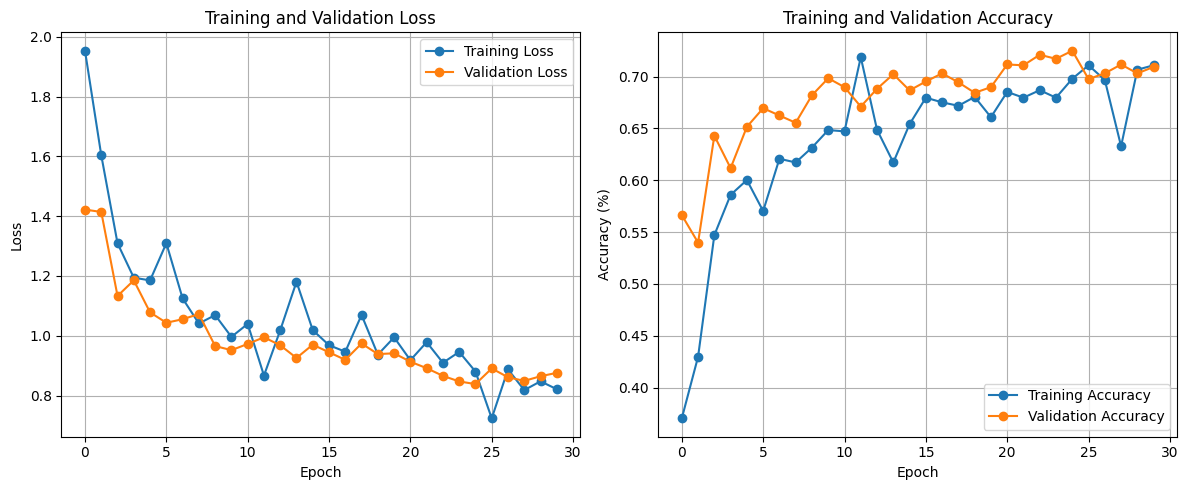

In [ ]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Performance evaluation

11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


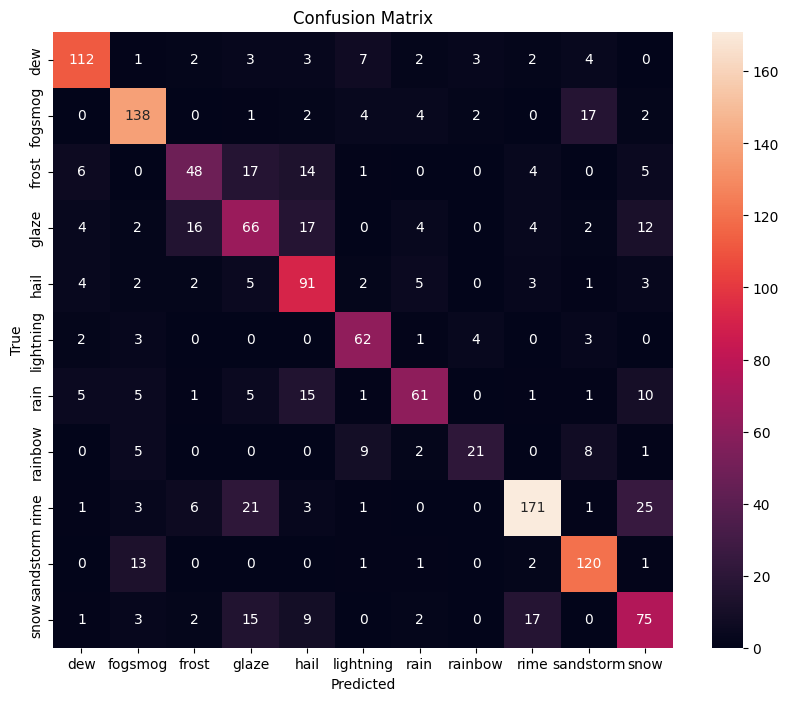

In [ ]:
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_steps)
predicted_classes = np.argmax(predictions, axis=1)

validation_generator.reset()
true_labels = []
batches = 0
for x, y in validation_generator:
    true_labels.extend(np.argmax(y, axis=1))
    batches += 1
    if batches >= validation_steps:
        break
true_labels = np.array(true_labels)
class_names = list(validation_generator.class_indices.keys())

cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('val_0.7094.keras')


Per-Class Metrics:
        Class  Precision    Recall  F1-Score  Support       AUC
0         dew   0.829630  0.805755  0.817518      139  0.974873
1     fogsmog   0.788571  0.811765  0.800000      170  0.981916
2       frost   0.623377  0.505263  0.558140       95  0.930777
3       glaze   0.496241  0.519685  0.507692      127  0.909347
4        hail   0.590909  0.771186  0.669118      118  0.943814
5   lightning   0.704545  0.826667  0.760736       75  0.987182
6        rain   0.743902  0.580952  0.652406      105  0.951899
7     rainbow   0.700000  0.456522  0.552632       46  0.963341
8        rime   0.838235  0.737069  0.784404      232  0.968266
9   sandstorm   0.764331  0.869565  0.813559      138  0.984760
10       snow   0.559701  0.604839  0.581395      124  0.911517

Macro-Average Metrics:
Macro Precision: 0.6945
Macro Recall: 0.6808
Macro F1-Score: 0.6816
Macro AUC: 0.9552


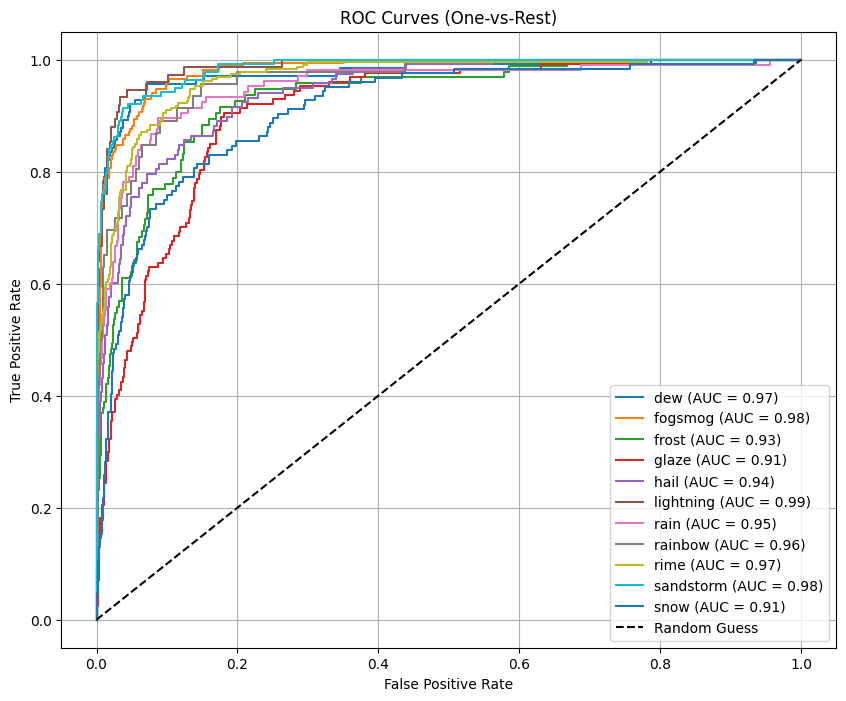

In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(true_labels, predicted_classes, average=None)

num_samples = validation_generator.samples
true_labels_one_hot = np.zeros((num_samples, len(class_names)))
for i in range(num_samples):
    true_labels_one_hot[i, true_labels[i]] = 1

auc_scores = []
for i in range(len(class_names)):
    auc = roc_auc_score(true_labels_one_hot[:, i], predictions[:, i])
    auc_scores.append(auc)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support,
    'AUC': auc_scores
})
print("\nPer-Class Metrics:")
print(metrics_df)

precision_macro = precision_recall_fscore_support(true_labels, predicted_classes, average='macro')[0]
recall_macro = precision_recall_fscore_support(true_labels, predicted_classes, average='macro')[1]
f1_macro = precision_recall_fscore_support(true_labels, predicted_classes, average='macro')[2]
auc_macro = roc_auc_score(true_labels_one_hot, predictions, average='macro', multi_class='ovr')

print("\nMacro-Average Metrics:")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-Score: {f1_macro:.4f}")
print(f"Macro AUC: {auc_macro:.4f}")

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='best')
plt.grid()
plt.show()

## Application

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


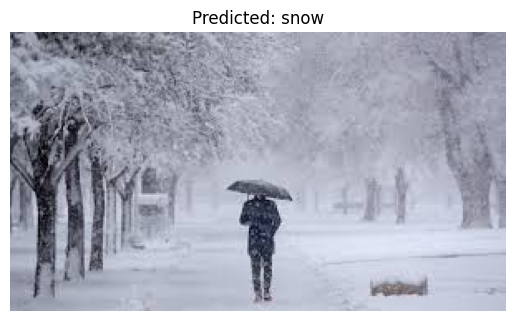

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = "snow2.jpeg"

preprocessed_image = preprocess_image(image_path)
predictions = model.predict(preprocessed_image)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_names = list(validation_generator.class_indices.keys())
predicted_class_name = class_names[predicted_class_index]

img = load_img(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()